In [1]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold

from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts

#Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.6.3, the latest is 0.6.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


#### 1. Load the data

N1
Commencing Training ...
1


/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


2
3
4

Duration: 106 seconds
Results Saved, on to next data type ...


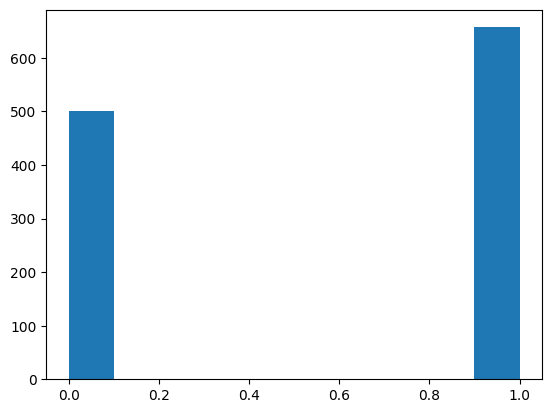

<Figure size 640x480 with 0 Axes>

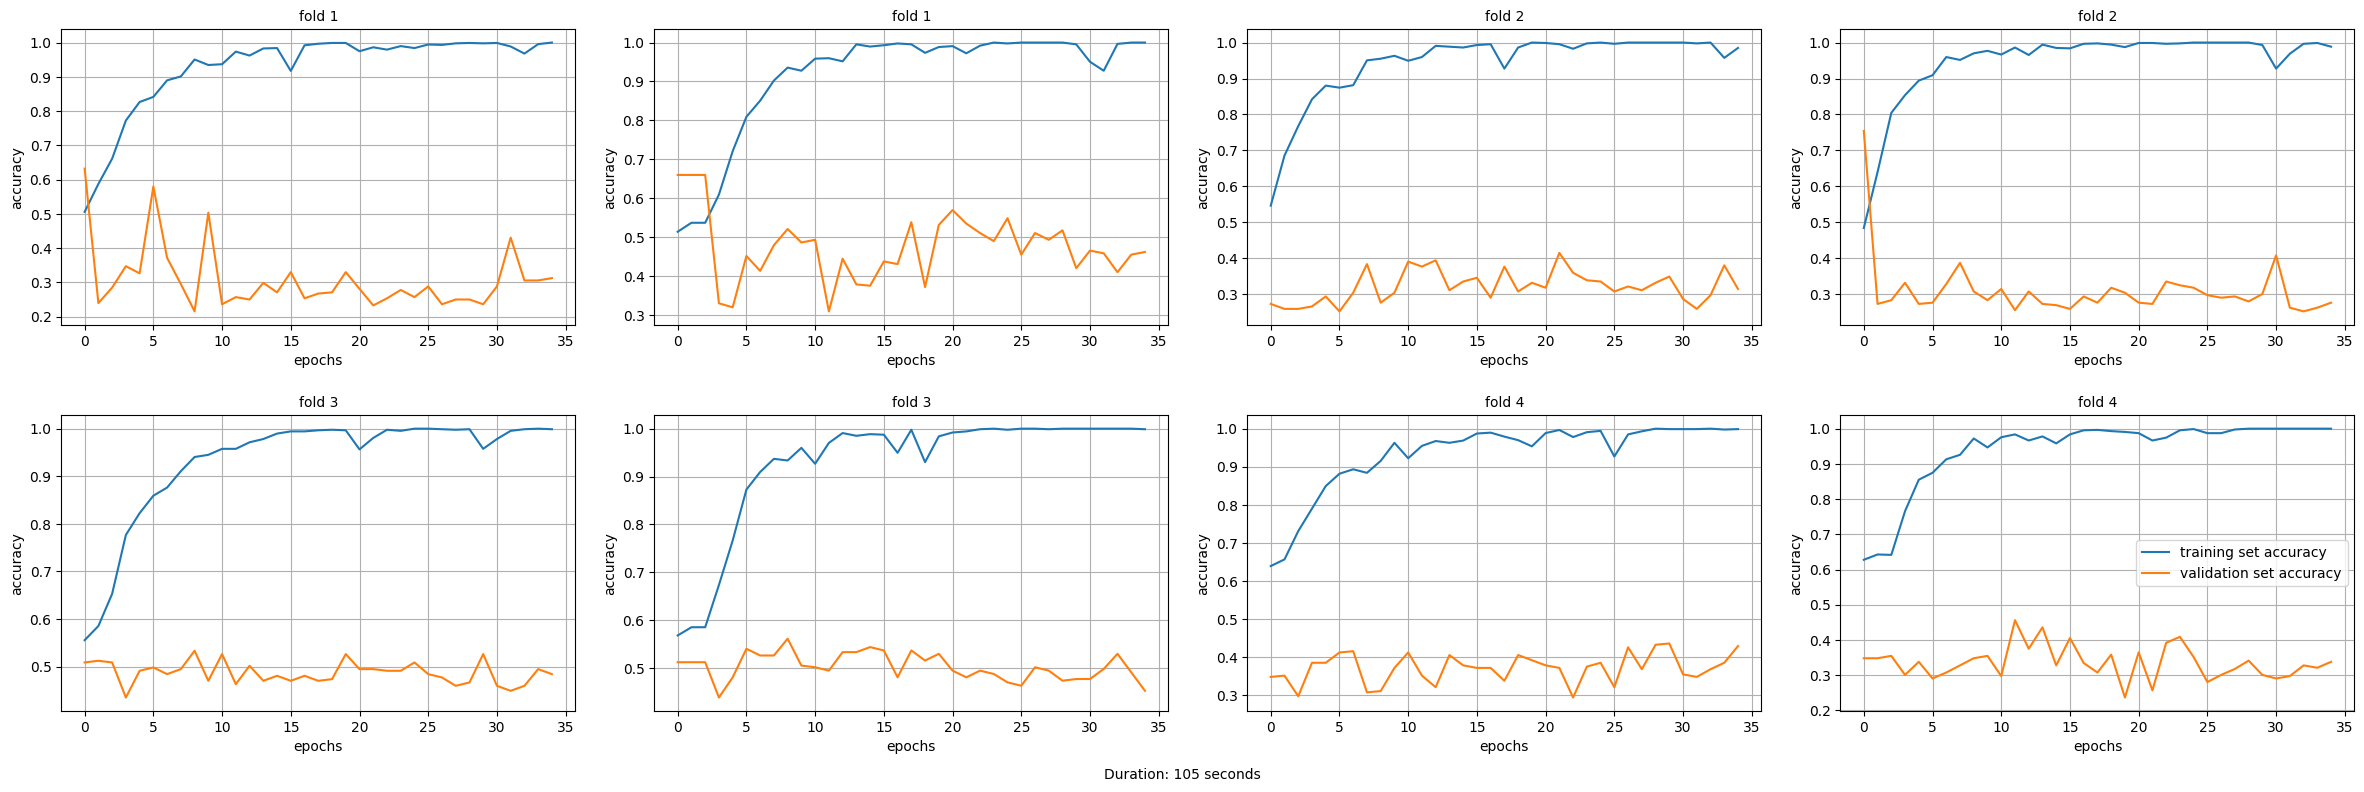

In [3]:
t1 = time.time()

#1.Load the data ________________________________________________________________________________________

for data_type in ['N1']:
    df_list = joblib.load(data_type + '_normalised_dataframes.pkl')
    
    print(data_type)
    
    df_list = [ df.iloc[::2].reset_index(drop=True) for df in df_list]
    
    
    # 1. generate all path names and class list(s) etc. 
    folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/'
    paths = joblib.load(folder + data_type + '_paths.pkl') # keys : ['selected_paths', 's_class_list', 's_night_list', 's_sleep_type', 's_p_id']
    
    class_label_dict = {'HC': 0 , 'PD' : 1 , 'PD+RBD' : 2 , 'RBD' : 3} #Dictionary used to label the classes for reference
    y = np.array([class_label_dict[c_name] for c_name in paths['s_class_list'] ] )
    groups = paths['s_p_id']
    
    wake_dfs_binary = []
    y_binary = []
    groups_binary = []
    
    for df , class_label , group in zip(df_list, y, groups):
        if class_label in [0,1]:
            wake_dfs_binary.append(df)
            y_binary.append(class_label)
            groups_binary.append(group)
    
    y_binary = np.array(y_binary)

#2. Generate 2 second segments of the data______________________________________________________________________ 

    #segment_length is user input and overlap is user input at the start of the script
    segment_length = 7680 
    overlap = 0.5
    
    signal_slices = []
    y_slice_labels = []
    y_slice_groups = []
    
    for df, label, group in zip(wake_dfs_binary, y_binary, groups_binary):
        
        num_segments = int( np.floor(len(df)/segment_length) )
        new_specs = []
        
        for i in np.arange(0,num_segments, 1 - overlap):
            if i > num_segments - 1 :
                # I don't want it to try to take an incomplete slice
                # will be an incomplete slice causing errors downstream, needs to stop 
                
                break
              
            start_index = int( np.floor(i*segment_length) )
            end_index = start_index + segment_length
            
            slice_df = df.iloc[start_index : end_index, :].copy()        
            signal_slices.append(slice_df)
            
            y_slice_labels.append(label)
            y_slice_groups.append(group)
            
    plt.hist(y_slice_labels)

#3. Select the correct channels ______________________________________________________________________________
    neuro_headset_channels = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]

    dif_channels = ['AF3', 'AF4'] #These channels are present in the neuro headset but not in my 57 EEG channels
    channels_to_add = ['AF7' , 'AF8']  #These channels are  present in my 57 EEG Channels
    channel_to_add_2 = ['Fp1' , 'Fp2'] #Alternatively I could add these two channels

    channel_list = constants.channel_list
    region_channel_dict = constants.region_to_channel_dict
    
    channel_to_region_dict = {}
    for key, value in region_channel_dict.items():
        for channel in value:
            channel_to_region_dict[channel] = key

    common_channels = []
    dif_channels = []
    for channel in neuro_headset_channels:
        if channel in channel_list: 
            common_channels.append(channel)
        else:
            dif_channels.append(channel)
    
    channels_to_add = ['AF7' , 'AF8'] 
    
    #Keep the channel ordering in line with original so append 'AF7' at the start and 'AF8' at the end
    common_channels.insert(0, 'AF7')
    common_channels.append('AF8')
    channels_selected = common_channels.copy()   

    # signal_slices, y_slice_labels, y_slice_groups
    signal_slices_14_channels = [ df.loc[:, channels_selected].copy() for df in signal_slices ]
    
    # Make the slices an np array of the correct dimensions
    signal_slices_14_channels_np = [df.T.values for df in signal_slices_14_channels]

#4. Create the network from the paper
    class PaperCNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv1d(14, 5, 100)
            
            self.bn1 = nn.BatchNorm1d(5)  # Batch norm after first conv layer
            
            self.conv2 = nn.Conv1d(5, 10, 10)
    
            self.conv3 = nn.Conv1d(10, 10, 10)
            
            self.conv4 = nn.Conv1d(10, 15, 5)       
            
            self.fc1 = nn.Linear(7020, 700)
            self.fc2 = nn.Linear(700,70)
            self.fc3 = nn.Linear(70,2)
            
        def forward(self, X):
            X = F.relu(self.bn1(self.conv1(X))) #Relu and BN on first conv layer
            X = F.max_pool1d(X,2) #first max pool layer
            
            X = F.relu(self.conv2(X)) #Relu on second conv layer
            X = F.max_pool1d(X,2) # second max pool layer
    
            X = F.relu(self.conv3(X)) #Relu on third conv layer
            X = F.max_pool1d(X,2) #Third Max pool layer
    
            X = F.relu(self.conv4(X)) #Relu on fourth conv layer
            X = F.max_pool1d(X,2) #Fourth Max pool layer
    
            X = X.view(-1, 7020) #Flatten the input
    
            X = F.relu(self.fc1(X) )
            X = nn.Dropout(p=0.5)(X) # Dropout after first FC layer as in the paper
    
            X = F.relu(self.fc2(X) )
            X = nn.Dropout(p=0.5)(X) # Dropout after first FC layer
            
            # X = F.softmax(self.fc3(X), dim = 1 ) 
            # Author uses softmax but doesn't state the loss function 
            # Author implies that loss function is cross entropy loss - however if we use this then we should remove the softmax from the network
    
            X = self.fc3(X) 
            
            return X

#5. Do Train Validation Splits
    # Train and Validation splits only ----> NO TEST
    # spectrogram_slices, y_slice_labels and y_slice_groups to work with
    train_val_dict = {}
    
    for value in ['train' , 'val']:
        train_val_dict[value] = {}
    
    X = np.stack(signal_slices_14_channels_np)
    y = np.array(y_slice_labels)
    groups = np.array( [int(group) for group in y_slice_groups] )
    
    gkf = GroupKFold(n_splits = 4) 
    fold = 0
    
    for train_index, val_index   in gkf.split(X, y, groups*1):
        fold += 1
        
        X_train, y_train, groups_train  = X[train_index], y[train_index] , groups[train_index]
        X_val, y_val, groups_val =  X[val_index], y[val_index] , groups[val_index]   
        
        train_val_dict['train'][fold] = X_train, y_train, groups_train
        train_val_dict['val'][fold]   = X_val, y_val, groups_val
        
        total_len = len(X) 
        val_percent = 100*(len(X_val) / total_len)
        train_percent = 100*(len(X_train) / total_len)
        
        # Commented out the printing here
        # print('fold ' + str(fold) ) 
        # print( str(train_percent)[:3] + ' | '  + str(val_percent)[:3] + ' |' )
    
        # # testing that the splits are as expected
        # print( np.unique(groups_train) )
        # print( np.unique(groups_val) )
        
        # print('__________________________________________________________________________')
    
    #Output from this section of code is X_train, y_train, groups_train AND X_test, y_test, groups_test 
    import time

    start_time = time.time()
    
    seeds = [2,40]
    rows = len(seeds) # Make the figure the right size 
    
    fig = plt.figure()
    fig = plt.figure(figsize=(24,4*rows),dpi=100)
    
    # k is for subplots within the overall figure 
    
    k = 1
    print('Commencing Training ...')
    for fold in [1,2,3,4]:
        print(fold)
        X_train, y_train, groups_train = train_val_dict['train'][fold]
        X_val, y_val, groups_val = train_val_dict['val'][fold]  
        
        # Creating train and test data loaders
        train_data = [ (torch.from_numpy(input_slice).float().view(14,7680), val) for input_slice, val in zip(X_train, y_train) ] 
        train_loader = DataLoader(train_data, batch_size=30, shuffle=True)
        
        val_data = [ (torch.from_numpy(input_slice).float().view(14,7680), val) for input_slice, val in zip(X_val, y_val) ] 
        val_loader = DataLoader(val_data , batch_size=30, shuffle=False)
        
       
        
        
        
        # for seed in [2,5,15,50]:
        for seed in seeds:
            # set all seeds 
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed) 
            
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            # print(device) - to check that device is actually cuda
            
            model = model = PaperCNN()
            model.to(device)
            
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr = 0.001 )
    
            epochs = 35
            train_losses = []
            val_losses = []
            test_losses = []
            
            train_correct = []
            val_correct = []
            test_correct = []
            
            for i in range(epochs):
                
                trn_corr = 0
                val_corr = 0
                tst_corr = 0
                 
                
                trn_loss = 0
                val_loss = 0
                tst_loss = 0
                
                model.train()
                # Run the training batches
                for b, (X_train_batch, y_train_batch) in enumerate(train_loader):
                    b+=1
            
                    #Move train data to the GPU
                    X_train_batch = X_train_batch.to(device)
                    y_train_batch = y_train_batch.to(device)
                    
                    # Apply the model
                    y_pred = model(X_train_batch)  # we don't flatten X-train here
                    loss = criterion(y_pred, y_train_batch)
             
                    # Tally the number of correct predictions
                    predicted = torch.argmax(y_pred.detach(),  dim = 1 ) 
    
                    predicted = predicted.reshape(y_train_batch.shape)
                    
                    batch_corr = (predicted == y_train_batch).sum()
                    trn_corr += batch_corr
                    trn_loss += loss
                    
                    # Update parameters
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                train_losses.append(trn_loss)
                train_correct.append(trn_corr)
            
                # Run the validation batches
                # Some of the variables in this loop have the same name as the variables in the above loop... be aware of that plz!
                model.eval()
                with torch.no_grad():
                    for b, (X_val_batch, y_val_batch) in enumerate(val_loader):
                        b+=1
                        
                        #Move train data to the GPU
                        X_val_batch = X_val_batch.to(device)
                        y_val_batch = y_val_batch.to(device)
            
                        # Apply the model
                        y_val = model(X_val_batch)
            
                        # Tally the number of correct predictions
                        predicted = torch.argmax(y_val.detach(),  dim = 1 ) 
                        predicted = predicted.reshape(y_val_batch.shape)
                        
                        batch_corr = (predicted == y_val_batch).sum()
                        val_corr += batch_corr
            
                        loss = criterion(y_val, y_val_batch)
                        val_loss += loss 
                       
                val_losses.append(val_loss)
                val_correct.append(val_corr)
            
                
               
            
            # Plot the outcome from the loop
            
            ax = fig.add_subplot(rows,4,k)
            k+=1
            plt.title('fold ' + str(fold), fontsize = 10)
            plt.plot([(val.cpu() / len(X_train) ) for val in train_correct], label='training set accuracy')
            plt.plot([(val.cpu()/len(X_val) ) for val in val_correct], label='validation set accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epochs') 
            plt.grid()
        
        
        plt.tight_layout()
    
    
    plt.legend()   
    plt.tight_layout()
    
    #Add text at the bottom of the figure
    # fig.text(0.5, 0, 'This is a caption at the bottom of the figure | Model : ' + str(model) , va='bottom')
    fig.text(0.5, 0, f'\nDuration: {time.time() - start_time:.0f} seconds' , ha='center', va='bottom')
    
    plt.tight_layout(pad = 2.0)
    
    save_name = data_type + '_' + 'Paper_CNN' + '_60_seconds_window'
    plt.savefig(save_name +'.png')
        
    
    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  
    print('Results Saved, on to next data type ...')
    
t2 = time.time()